# 模型選擇&評估

* 交叉驗證(Cross-Validation)  
    估計模型在面對**從沒有見過的數據**，它的的預測能力，也就是模型的泛化能力。
    * K-fold cross-validation
    * Stratified K-fold cross-validation  
* 學習曲線(Learning curve)  
    透過調整樣本數診斷訓練模型擬合(fit)的情況，Overfitting(high variance)，Underfitting(high bias)
* 驗證曲線(Validation curve)  
    透過調整超參數診斷訓練模型擬合(fit)的情況，Overfitting(high variance)，Underfitting(high bias)  


## 資料預處理

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#df = pd.read_csv('data/wdbc.data', header=None)
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1,solver='liblinear'))

## k-Fold 交叉驗證法 K-fold cross-validation
基本Kfold概念:  
<img src="image/pipeLine.png" width="500">  
隨機將資料分割K份，其中1份用於驗證，其餘K-1份用於訓練模型。但是這樣會產生一個問題，尤其當目標特徵類別不平衡時最容易發生，就是有可能在某份或多份被切割的資料裡只有一個類別的情況，如下圖Scikit Learn官網所示的圖形:  

<img src="image/scikit_Kfold.png" width="500">  


## 分層k-Fold 交叉驗證法 Stratified K-fold cross-validation

每份被切割的數據中的目標特徵的類別比例都與原始**訓練數據**相同，它可以產生較好的bias與variance平衡的估計.(Ron Kohavi et al. [A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection],International Joint Conference on Artificial Intelligence(IJCAI),14(12),1137-1145,1995)

如Scikit Learn官網所示圖形:  

<img src="image/scikit_stratifiedKFold.png" width="500">  


In [2]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('第 %2d 份, 0&1次數: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]),
          score)) # 0和1的count
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

第  1 份, 0&1次數: [256 153], Acc: 0.935
第  2 份, 0&1次數: [256 153], Acc: 0.935
第  3 份, 0&1次數: [256 153], Acc: 0.957
第  4 份, 0&1次數: [256 153], Acc: 0.957
第  5 份, 0&1次數: [256 153], Acc: 0.935
第  6 份, 0&1次數: [257 153], Acc: 0.956
第  7 份, 0&1次數: [257 153], Acc: 0.978
第  8 份, 0&1次數: [257 153], Acc: 0.933
第  9 份, 0&1次數: [257 153], Acc: 0.956
第 10 份, 0&1次數: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## 分層K-fold 計分器

In [3]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)#使用幾個cpu or 核心
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## 學習曲線(Learning curve) 

<img src="image/LearningCurve.png" width="500">  

* 理想準確率實務上很難取得，你也不知道針對這專案理想準確會是多少，理論上當然是越高越好，以我的經驗理想準確率我會搭配成本以及類別比率進行估計  
* High bias 訓練與驗證曲線都偏低，表示Underfitting訓練數據集。這問題通常是模型學習不到模式(Pattern)要進行
    1. 更多的特徵工程(建立組合新特徵)
    2. 收集額外的特徵
    3. 降低正規化的強度
* High Variance 訓練與驗證曲線差異過大，表示Overfitting訓練數據集。
    這問題是因為模型太複雜，所以
    1. 可以透過收集更多的數據集(通常很難而且需要時間，常常沒辦法達成專案就要先推到一個進度)
    2. 加強正規化參數的強度
    3. 降維

* 當然也有可能同時包含High bias和High Variance，通常這樣就表示模型根本就沒再學習，通常這樣我會著手朝特徵方面著手，以及再檢查一次資料方面有沒有問題是之前沒有注意到的情況，也就是再回到特徵工程以及回到業務知識方面跟業務人員再確認一次。

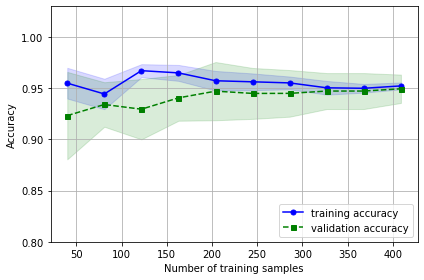

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr, 
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10), #r seq  0.1 0.2...1
                               cv=10,#預設使用分層k-fold
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

#訓練集的標準差區間
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

#測試集的標準差區間
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

## 驗證曲線(Validation curve)

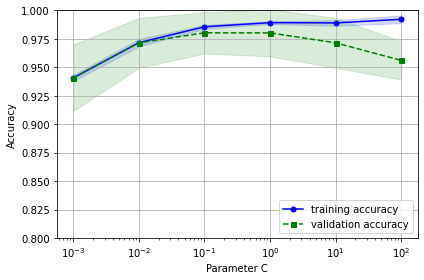

In [5]:
from sklearn.model_selection import validation_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='liblinear'))
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

從上圖驗證曲線中我們Tune的超參數是邏輯式迴歸的反正規化參數C，提高正規化強度(較小的C)，模型有點Underfitting，降低強度(較大的C)則有點Overfitting(過度擬合了訓練資料，測試集準確度反而下降)。  
比較理想的C值應該是介於0.01~0.1之間

# Tune超參數  
* 網格搜尋(Grid Search)  
    使用暴力法以窮舉的方式搜尋我們所輸入的超參數全部的組合來找出最好的組合。  
* 巢狀交叉驗證(Nested cross-validation)
    結合Grid Search和Cross-validation來tune超參數。  
    外折(outer fold):將數據集切割成訓練集和測試集  
    內折(inner fold):使用訓練集來Tune超參數。  
    示意圖:  
    <img src="image/NestedCrossValidation.png" width="500">  

    

## 網格搜尋Grid Search
下面將透過Grid Search tune SVM的超參數組合，分別是線性Kernel,rbf Kernel,C和gamma值。  

In [6]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

#字典
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1 #使用全部
                 )
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


## 巢狀交叉驗證(Nested cross-validation)
下面將演示5個外折2個內折的5x2巢狀交叉驗證SVM

In [7]:
#內折
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
#外折
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [8]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


SVM vs 決策樹，目前單一以準確度來說，我們可以推估這資料集SVM會比較好。但是對決策樹比較不公平點，因為我們只Tune了一個超參數。